# Cat and Dog Image Classifier
In this project, we classify images of dogs and cats. For this we use TensorFlow 2.0 and Keras to create a convolutional neural network that correctly classifies the images of dogs and cats.

In [ ]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D,  BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))


In [ ]:
# Variables for pre-processing and training.
batch_size = 32
IMG_HEIGHT = 128
IMG_WIDTH = 128

# Data Augmentation
To avoid overfitting and create a larger dataset from a smaller one we can use a technique called data augmentation. This is simply performing random transformations on our images so that our model can generalize better. These transformations can be things like compressions, rotations, stretches and even color changes.

Fortunately, keras can help us do this. Look at the code below to an example of data augmentation.

In [ ]:
# 3
# creates a data generator object that transforms images
# Since there are a small number of training examples, there is a risk of overfitting. 
#One way to fix this problem is by creating more training data from existing training examples by using random transformations.

# creates a data generator object that transforms images
train_image_generator = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 40,
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    shear_range = 15,
    horizontal_flip=True,
    zoom_range = [0.5, 1.5]
)
# We use the rescale argument to rescale the tensors from values between 0 and 255 to values between 0 and 1.
image_generator = ImageDataGenerator(
    rescale=1. / 255
)

#Generators for training, validation and test sets
train_data_gen = train_image_generator.flow_from_directory(train_dir, 
                                                           target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                          batch_size=batch_size,
                                                           class_mode = 'binary',  
                                                           shuffle=True)

val_data_gen = image_generator.flow_from_directory(validation_dir, 
                                           target_size=(IMG_HEIGHT,IMG_WIDTH),
                                           class_mode = 'binary',
                                          batch_size=batch_size, 
                                          shuffle=True) 

#For test_data_gen, we will pass in shuffle=False to the flow_from_directory method. This will make sure the final predictions stay is in the order that our test expects.
test_data_gen = image_generator.flow_from_directory('cats_and_dogs',
                                                    target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                    batch_size=32, 
                                                    classes=['test'], 
                                                    shuffle=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


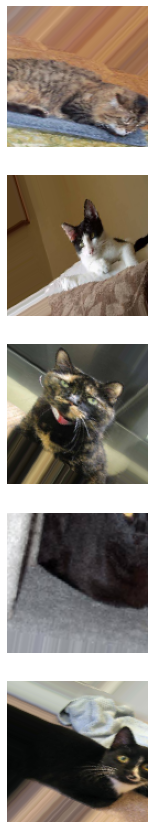

In [ ]:
# Checking our images.
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])



# CNN Architecture

In [ ]:
# 7
# A common architecture for a CNN is a stack of Conv2D and MaxPooling2D layers followed by a few denesly connected layers. 
# The idea is that the stack of convolutional and maxPooling layers extract the features from the image. 
# The purpose of Dropout is to prevent overfitting, thus aiding network generalization.
# Batch normalization helps stabilize training and makes it easier to tune hyperparameters.
# Then these features are flattened and fed to densly connected layers that determine the class of an image based on the presence of features.

# Convolutrional layers.
modelCNN = Sequential()
modelCNN.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))),
modelCNN.add(BatchNormalization()),
modelCNN.add(MaxPooling2D(2, 2)),
modelCNN.add(Dropout(0.25))

modelCNN.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))),
modelCNN.add(BatchNormalization()),
modelCNN.add(MaxPooling2D(2, 2)),
modelCNN.add(Dropout(0.25))

modelCNN.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))),
modelCNN.add(BatchNormalization()),
modelCNN.add(MaxPooling2D(2, 2)),
#Adding Dense Layers
modelCNN.add(Dropout(0.5)),
modelCNN.add(Flatten()),
modelCNN.add(Dense(128, activation='relu', kernel_initializer='glorot_uniform')),
#Finally, we will add the prediction layer that will be a single dense neuron. 
#We can do this because we only have two classes to predict for.
modelCNN.add(Dense(1, activation='sigmoid'))


In [ ]:
# Let's check our network.
modelCNN.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_26 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 64, 64, 32)        0         
                                                                 
 conv2d_33 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_27 (Bat  (None, 64, 64, 64)     

Now we will compile the model.

In [ ]:
#Compile models. Use binary crossentropy since we have only 2 options (dog or cat)
modelCNN.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Training
Using the fit method on our model to train the networks. 

In [ ]:
modelCNN.fit(
    train_data_gen,
    epochs=50, 
    validation_data=val_data_gen,
    steps_per_epoch=int(total_train / float(32)),
    validation_steps=int(total_val / float(32)),
)

Epoch 1/50
62/62 [==============================] - 17s 243ms/step - loss: 2.8369 - accuracy: 0.5340 - val_loss: 0.9631 - val_accuracy: 0.5514
Epoch 2/50
62/62 [==============================] - 14s 220ms/step - loss: 0.6812 - accuracy: 0.5351 - val_loss: 1.8086 - val_accuracy: 0.5272
Epoch 3/50
62/62 [==============================] - 14s 223ms/step - loss: 0.6676 - accuracy: 0.5859 - val_loss: 2.2791 - val_accuracy: 0.5222
Epoch 4/50
62/62 [==============================] - 14s 223ms/step - loss: 0.6486 - accuracy: 0.5986 - val_loss: 0.9364 - val_accuracy: 0.5847
Epoch 5/50
62/62 [==============================] - 14s 225ms/step - loss: 0.6410 - accuracy: 0.6138 - val_loss: 0.7302 - val_accuracy: 0.6210
Epoch 6/50
62/62 [==============================] - 14s 227ms/step - loss: 0.6387 - accuracy: 0.6392 - val_loss: 0.7899 - val_accuracy: 0.5867
Epoch 7/50
62/62 [==============================] - 14s 227ms/step - loss: 0.6202 - accuracy: 0.6316 - val_loss: 0.6740 - val_accuracy: 0.5454

# Testing the model
Using our model to predict whether a brand new image is a cat or a dog.
We get the probability that each test image (from test_data_gen) is a dog or a cat. We will call the plotImages function and pass in the test images and the probabilities corresponding to each test image.

After running the cell, we'll see the 50 test images with a label showing the percentage of "sure" that the image is a cat or a dog. The precision will correspond to the precision shown in the graph above (after executing the previous cell).

2/2 [==============================] - 0s 68ms/step


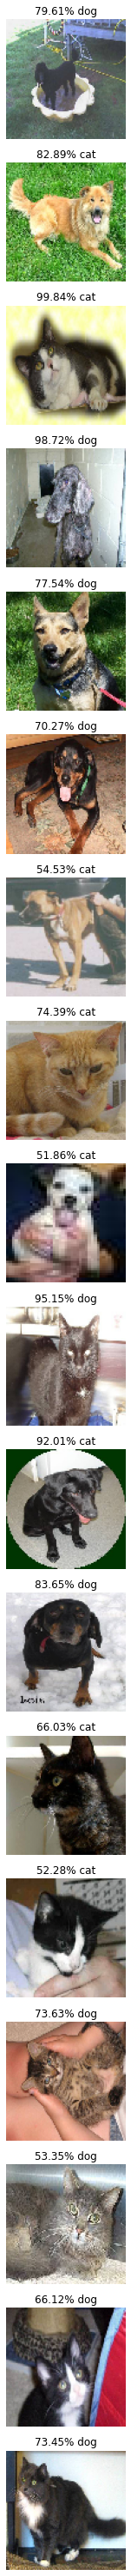

In [ ]:
prediction = modelCNN.predict(test_data_gen)
sample_training_images, _ = next(test_data_gen)
plotImages(sample_training_images, prediction)

##Using a Pretrained Model
To improve the performance, use a pretrained model and fine tuning to classify images of dogs and cats using a small dataset.




In [ ]:
import tensorflow_hub as hub

IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

# Create the base model from the pre-trained model MobileNet V2
mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

###Freezing the Base
The term **freezing** refers to disabling the training property of a layer. It simply means we won’t make any changes to the weights of any layers that are frozen during training. This is important as we don't want to change the convolutional base that already has learned weights.



In [ ]:
mobilenetv2.trainable = False

###Adding our Classifier
Now that we have our base layer setup, we can add the classifier. Instead of flattening the feature map of the base layer we will use a global average pooling layer that will average the entire 5x5 area of each 2D feature map and return to us a single 1280 element vector per filter.  



In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

Finally, we will add the predicition layer that will be a single dense neuron. We can do this because we only have two classes to predict for.




In [ ]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

Now we will combine these layers together in a model.

In [ ]:
cat_dog_classifier = tf.keras.Sequential([
  mobilenetv2,
  global_average_layer,
  prediction_layer
])

In [ ]:
cat_dog_classifier.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_7   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_23 (Dense)            (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


###Training the Model
Now we will train and compile the model. We will use a very small learning rate to ensure that the model does not have any major changes made to it.

In [ ]:
base_learning_rate = 0.001
cat_dog_classifier.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# We can evaluate the model right now to see how it does before training it on our new images
initial_epochs = 100
validation_steps = 32

loss0,accuracy0 = cat_dog_classifier.evaluate(val_data_gen, steps = validation_steps, batch_size=32)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


32/32 [==============================] - 4s 99ms/step - loss: 0.8236 - accuracy: 0.4890


In [ ]:
# Now we can train it on our images
history = cat_dog_classifier.fit(train_data_gen,
                    epochs=initial_epochs,
                    validation_data=val_data_gen)

acc = history.history['accuracy']
print(acc)

Epoch 1/100
63/63 [==============================] - 18s 251ms/step - loss: 0.4560 - accuracy: 0.7680 - val_loss: 0.1628 - val_accuracy: 0.9360
Epoch 2/100
63/63 [==============================] - 16s 251ms/step - loss: 0.3139 - accuracy: 0.8610 - val_loss: 0.1296 - val_accuracy: 0.9540
Epoch 3/100
63/63 [==============================] - 16s 253ms/step - loss: 0.2813 - accuracy: 0.8765 - val_loss: 0.1128 - val_accuracy: 0.9580
Epoch 4/100
63/63 [==============================] - 16s 249ms/step - loss: 0.2776 - accuracy: 0.8805 - val_loss: 0.1098 - val_accuracy: 0.9590
Epoch 5/100
63/63 [==============================] - 16s 249ms/step - loss: 0.2630 - accuracy: 0.8785 - val_loss: 0.0946 - val_accuracy: 0.9660
Epoch 6/100
63/63 [==============================] - 15s 244ms/step - loss: 0.2671 - accuracy: 0.8840 - val_loss: 0.0916 - val_accuracy: 0.9670
Epoch 7/100
63/63 [==============================] - 15s 245ms/step - loss: 0.2446 - accuracy: 0.8895 - val_loss: 0.0881 - val_accuracy:

2/2 [==============================] - 1s 53ms/step


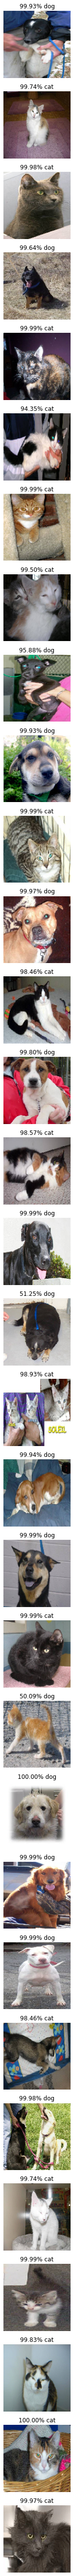

In [ ]:
#Let's predict whether a brand new image is a cat or a dog
prediction = cat_dog_classifier.predict(test_data_gen)
sample_training_images, _ = next(test_data_gen)
plotImages(sample_training_images, prediction)

In [ ]:
cat_dog_classifier.save("cat_dog_classifier.h5")  #Now we can save the model and reload it at anytime in the future
new_model = tf.keras.models.load_model('cat_dog_classifier.h5')